Link to the dataset https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758026
How to deal with licence https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images#DownloadingTCIAImages-DownloadingImagesUsingtheNBIADataRetriever
CT https://www.youtube.com/watch?v=JKf1Q4DOfs0


To work with medical images you need to download special library

In [ ]:
#%pip install pydicom --user

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from pydicom import dcmread #reads .dcm file having path to it

In [72]:
dataset_dir = 'manifest-1643214718297/LDCT-and-Projection-data/'
patient = 'C002/'

projections = '08-30-2018-NA-NA-57448/'
images = '12-23-2021-NA-NA-62464/'

full_dose = '1.000000-Full dose projections-22835/'
low_dose = '1.000000-Low dose projections-86837/'

im_full_dose = 'Full_dose/'

Here is schematic directory structure.

Every patient is denoted with capital letter and personal number (e.g. 'C002', 'L033'). Capital letters can be of 3 types: "C" is for chest, 'N' is for neural CT (brain) and 'L' is for liver (abdominal CT)

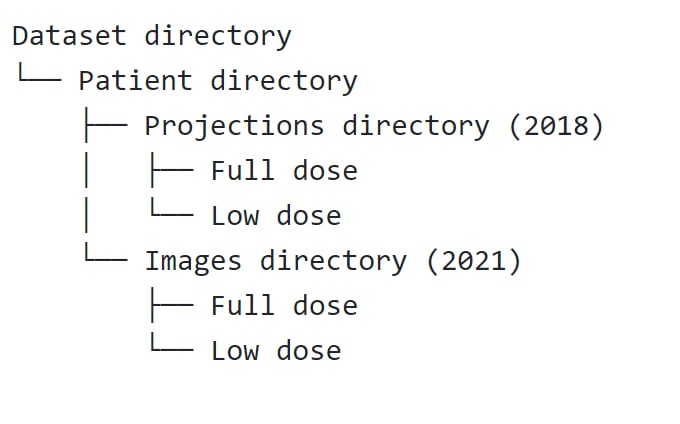

In [75]:
filename = dataset_dir + patient + projections + full_dose +'1-00501.dcm' #'test_data/Full_dose/1-00001.dcm'

sample = dcmread(filename)
print(sample)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Raw Data Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113713.4.2.357697738711643714217699608680593133347
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Raw Data Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113713.4.2.357697738711643714217699608680593133347
(0008, 0020) Study Date                          DA: '20180830'
(0008, 0021) Series Date                         DA: '20180830'


Function to read tags of DCM file

In [73]:
import struct
VR2type = {'FL': 'f', 'US': 'H', 'CS': 'str', 'DS': 'str'}
VRsizes = {'FL': 4, 'US': 2, 'CS': 16, 'DS': 16}


def read_private_data(proj, group, elem, VR):
    
    private_creator = proj.private_creators(group)[0]
    b_val = proj.get_private_item(group, elem, private_creator).value

    if VR == 'CS':
        return b_val.decode()
    if VR == 'DS':
        return float(b_val.decode())

    count = len(b_val) // VRsizes[VR]
    if count == 1: return struct.unpack(VR2type[VR], b_val)[0]
    return struct.unpack(VR2type[VR] * count, b_val)

        
def get_private_data(proj):
    data = dict()
    data['num_rows'] = read_private_data(proj, 0x7029, 0x0010, 'US')
    data['num_cols'] = read_private_data(proj, 0x7029, 0x0011, 'US')
    data['col_width'] = read_private_data(proj, 0x7029, 0x0002, 'FL') #mm
    data['row_width'] = read_private_data(proj, 0x7029, 0x0006, 'FL') #mm
    data['detector_shape'] = read_private_data(proj, 0x7029, 0x000B, 'CS')
    data['angular_pos'] = read_private_data(proj, 0x7031, 0x0001, 'FL') #rad
    data['axial_pos'] = read_private_data(proj, 0x7031, 0x0002, 'FL') #mm
    data['radial_pos'] = read_private_data(proj, 0x7031, 0x0003, 'FL') #mm
    data['s-d_dist'] = read_private_data(proj, 0x7031, 0x0031, 'FL')
    data['detector_centre'] = read_private_data(proj, 0x7031, 0x0033, 'FL')
    data['angular_bias'] = read_private_data(proj, 0x7033, 0x000B, 'FL') #rad
    data['axial_bias'] = read_private_data(proj, 0x7033, 0x000C, 'FL') #mm
    data['radial_bias'] = read_private_data(proj, 0x7033, 0x000D, 'FL') #mm
    
    data['num_of_proj'] = read_private_data(proj, 0x7033, 0x0013, 'US')
    data['NumberofSpectra'] = read_private_data(proj, 0x7033, 0x0061, 'US')
    data['SpectrumIndex'] = read_private_data(proj, 0x7033, 0x0063, 'US')
#     data['photon_distr'] = read_private_data(proj, 0x7033, 0x0065, 'FL')
#     data['time_stamp'] = read_private_data(proj, 0x7033, 0x0067, 'FL') #doesn't exist
    
    data['proj_data_type'] = read_private_data(proj, 0x7037, 0x0009, 'CS')
    data['proj_geom_type'] = read_private_data(proj, 0x7037, 0x000A, 'CS')
    
    data['BeamHardeningCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0003, 'CS')
    data['GainCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0004, 'CS')
    data['DarkFieldCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0005, 'CS')
    data['FlatFieldCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0006, 'CS')
    data['BadPixelCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0007, 'CS')
    data['ScatterCorrectionFlag'] = read_private_data(proj, 0x7039, 0x0008, 'CS')
    data['LogFlag'] = read_private_data(proj, 0x7039, 0x0008, 'CS')
    
    data['WaterAttenuationCoefficient'] = read_private_data(proj, 0x7041, 0x0001, 'DS')
    
    return data

Several important parametrs

In [76]:
rows = get_private_data(sample)['num_rows']
cols = get_private_data(sample)['num_cols']
print(f'Detector size is {cols} x {rows}')

Detector size is 736 x 64


In [18]:
proj_type = get_private_data(sample)['proj_data_type']
print(proj_type)

HELICAL 


Data 

In [77]:
print(sample.pixel_array)
print(f'Shape of each projection is {sample.pixel_array.shape}')

[[1051 1012 1005 ...  986  986  986]
 [ 979  971 1021 ...  918  918  918]
 [1028 1021 1002 ...  923  923  923]
 ...
 [1052 1034 1042 ...  974  974  974]
 [1100 1050 1070 ...  981  981  981]
 [ 984 1050 1064 ... 1023 1023 1023]]
Shape of each projection is (736, 64)


Vizualisation

In [78]:
#concat all files from directory
def img_3d_from_dir(data_dir):
    file_list=os.listdir(data_dir)
    #print(file_list)
    all_imgs=[]
    for f in file_list:
        dcm = data_dir+'/'+f
        dcm_1 = dcmread(dcm)
        im_1=dcm_1.pixel_array
        all_imgs.append(im_1)
    img_3d=np.stack(all_imgs)
    return img_3d  

In [80]:
Projections = img_3d_from_dir(dataset_dir + patient + projections + full_dose)
print(Projections.shape)
#Num_projections x detector_H x detector_W

(11072, 736, 64)


In [40]:
Images = img_3d_from_dir(dataset_dir + patient + images + im_full_dose)
print(Images.shape)

(280, 512, 512)


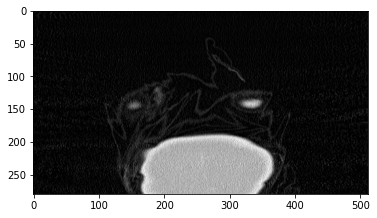

In [41]:
plt.imshow(Images[:,100, :], cmap='gray')

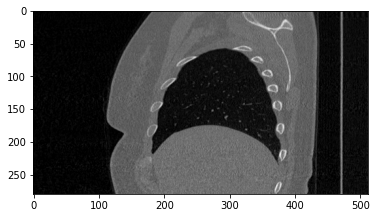

In [42]:
plt.imshow(Images[:,:,100], cmap='gray')

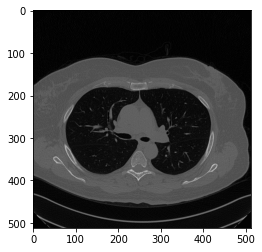

In [43]:
plt.imshow(Images[100,:, :], cmap='gray')

In [44]:
#Some statistics
#print(Images)
print(np.min(Images))
print(np.max(Images))
print(np.mean(Images))
print(np.std(Images))

0
4095
502.5655930655343
480.1630654068542


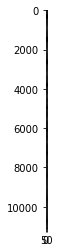

In [81]:
plt.imshow(Projections[:,200, :], cmap='gray')

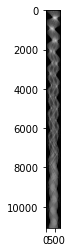

In [82]:
plt.imshow(Projections[:,:,30], cmap='gray')

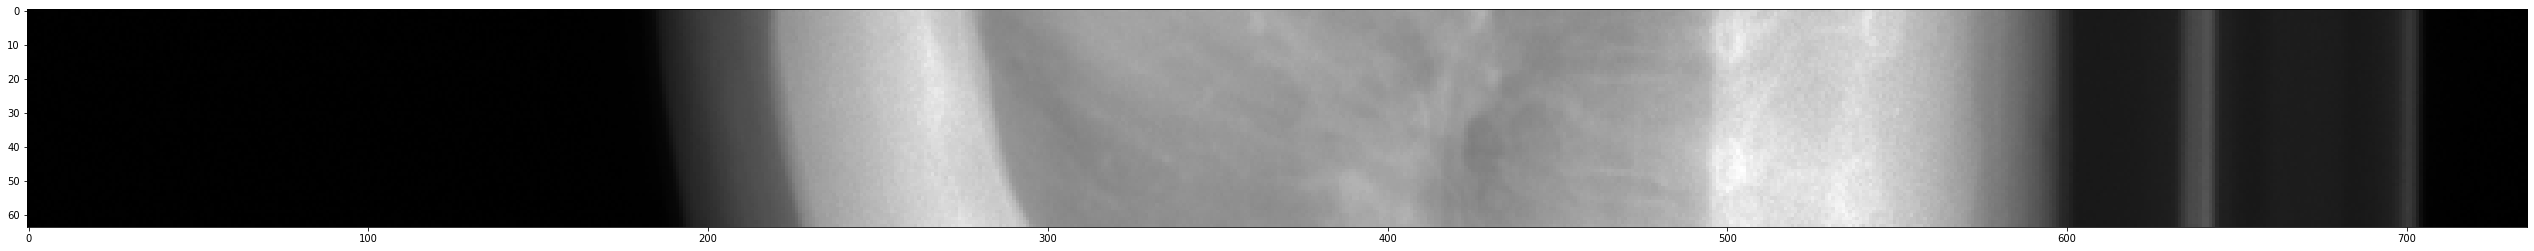

In [102]:
plt.figure(figsize = (46,4))
plt.imshow(Projections[5000,:, :].T, cmap='gray')

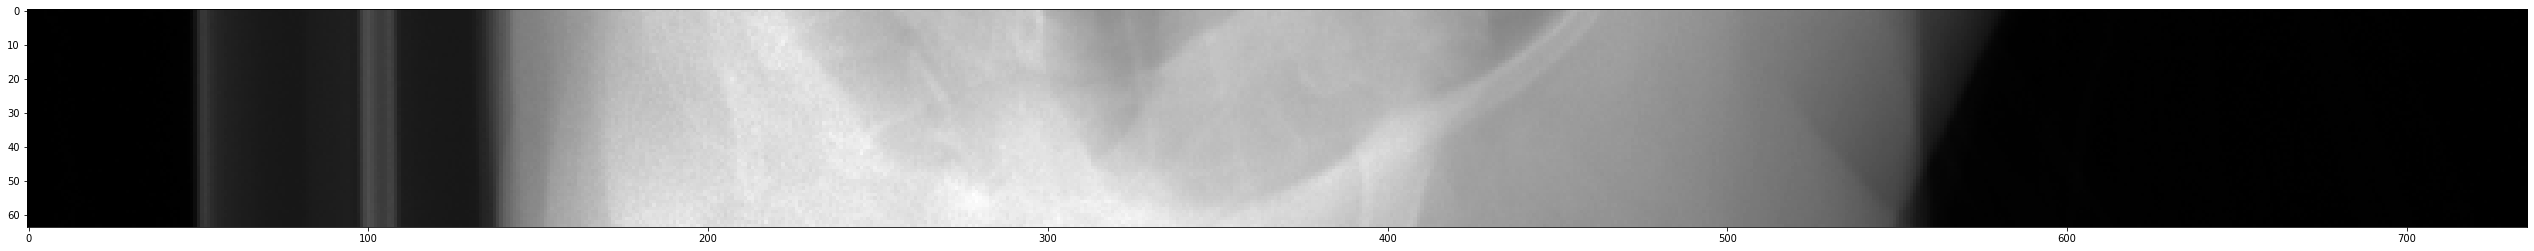

In [56]:
plt.figure(figsize = (46,4))
plt.imshow(Projections[2010,:, :].T, cmap='gray')

In [49]:
#Some statistics
#print(Images)
print(np.min(Projections))
print(np.max(Projections))
print(np.mean(Projections))
print(np.std(Projections))

0
65535
15397.89470489686
11227.287447554765


In [50]:
#after decompression return to the same space (uint16)

In [ ]:
#another example
dataset_dir = 'manifest-1648648375084/LDCT-and-Projection-data/'
patient = 'C002/'

projections = '08-30-2018-NA-NA-57448/'
images = '12-23-2021-NA-NA-62464/'

full_dose = '1.000000-Full dose projections-22835/'
low_dose = '1.000000-Low dose projections-86837/'

im_full_dose = 'Full_dose/'

In [3]:
dataset_dir = 'manifest-1648648375084/LDCT-and-Projection-data/'
patient = 'L033/'

projections = '08-28-2018-NA-NA-93540/'
#images = '12-23-2021-NA-NA-62464/'

full_dose = '1.000000-Full dose projections-02630/'
#low_dose = '1.000000-Low dose projections-86837/'

#im_full_dose = 'Full_dose/'

In [6]:
Projections = img_3d_from_dir(dataset_dir + patient + projections + full_dose)
print(Projections.shape)

(39822, 736, 64)


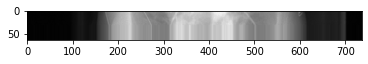

In [16]:
plt.imshow(Projections[1200,:, :].T, cmap='gray')

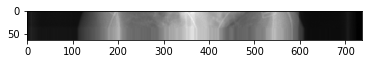

In [20]:
plt.imshow(Projections[1500,:, :].T, cmap='gray')

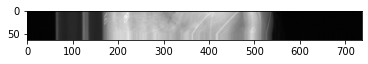

In [24]:
plt.imshow(Projections[2000,:, :].T, cmap='gray')

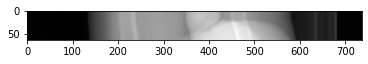

In [23]:
plt.imshow(Projections[38000,:, :].T, cmap='gray')

In [ ]:
plt.imshow(Projections[39000,:, :].T, cmap='gray')

C004 from 800 to 12500

In [30]:
dataset_dir = 'manifest-1643214718297/LDCT-and-Projection-data/'
patient = 'C004/'

projections = '08-30-2018-NA-NA-33450/'
#images = '12-23-2021-NA-NA-62464/'

full_dose = '1.000000-Full dose projections-47507/'
#low_dose = '1.000000-Low dose projections-86837/'


In [31]:
Projections = img_3d_from_dir(dataset_dir + patient + projections + full_dose)
print(Projections.shape)

(13782, 736, 64)


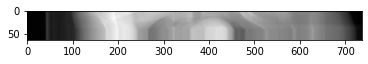

In [53]:
plt.imshow(Projections[700,:, :].T, cmap='gray')

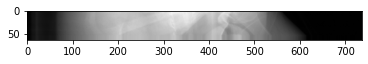

In [39]:
plt.imshow(Projections[1000,:, :].T, cmap='gray')

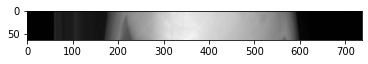

In [71]:
plt.imshow(Projections[11100, :, :].T, cmap='gray')

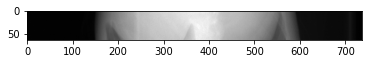

In [63]:
plt.imshow(Projections[10500, :, :].T, cmap='gray')

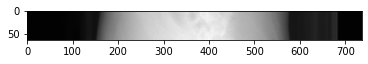

In [42]:
plt.imshow(Projections[12000, :, :].T, cmap='gray')